# Predictive Model for Heart Disease Detection

**Done by:** Nga Wei En + Lin HongChao + Bai YiFan 

## Project Objective 

The primary goal of this project is to develop a robust predictive model that can accurately determine the likelihood of heart disease in individuals based on a comprehensive set of variables including lifestyle choices, health factors, and biodemographic information. This model aims to address the critical need for early diagnosis and management of heart disease, which remains the leading cause of death in the U.S.

1. Utilize the extensive dataset from the 2022 annual CDC survey, which includes data from over 400,000 adults, to capture a wide range of factors that potentially influence heart health.
2. Employ machine learning techniques to prepare and analyze the data, focusing on handling imbalances, enhancing data quality, and extracting meaningful insights from the health variables.
3. To identify the most effective model, compare the performance of different predictive models—namely, Decision Trees, Random Forests, and Neural Networks—in terms of accuracy, precision, recall, F1-score, and AUC.
4. Implement advanced resampling techniques to ensure the model is trained on a representative sample of the population, thereby improving its generalizability and reliability.

By the conclusion of this project, we expect to deliver a predictive tool that healthcare professionals can use to identify patients at high risk of heart disease more efficiently and accurately. This result will also provide insights into heart disease's most influential risk factors, supporting targeted preventive measures and personalized healthcare strategies.

## Import Necessary Library

In [2]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc_context

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import StratifiedKFold

from tensorflow import keras
from tensorflow.keras import layers

from scipy.stats import chi2_contingency, pointbiserialr, chi2_contingency

from sklearn.base import BaseEstimator, ClassifierMixin
from eli5.sklearn import PermutationImportance
import eli5

from  imblearn.over_sampling import KMeansSMOTE

import warnings    
warnings.filterwarnings("ignore")

plt.style.use("default")

## One Hot Encoding
The primary goal of implementing One Hot Encoding in our heart disease prediction project is to transform categorical variables into a format that can be provided to machine learning algorithms to improve model performance. One Hot Encoding converts categorical data into binary or dummy variables, each representing a unique category level. This process is crucial for the preparation and effective utilization of the dataset within predictive models.

Specific Goals:

1. Data Preprocessing:
Convert all categorical variables into a format that is interpretable by machine learning models. Since most algorithms cannot handle categorical variables directly, One Hot Encoding ensures that these variables are represented in a binary numeric format.
2. Enhance Model Interpretability:
Facilitate better interpretation and significance of categorical variables within the model by breaking them down into individual binary features. Each one-hot encoded column explicitly represents the presence or absence of a category, making the model's decisions more interpretable.
3. Remove Ordinality:
Eliminate any implicit ordering that might be introduced by other encoding methods like label encoding. One Hot Encoding treats each category as equally important without implying any sort of order (which might not exist).
4. Improve Model Accuracy:
Enable more accurate and efficient processing of data by learning algorithms, especially those that are sensitive to numerical inputs and require numerical consistency like logistic regression and neural networks.
5. Support for Various Machine Learning Models:
Prepare the data in a way that is compatible with a variety of machine learning algorithms, thereby supporting extensive experimentation and optimization of different models to find the best fit for predicting heart disease.

In [107]:

def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal weight'
    elif bmi < 30:
        return 'Overweight'
    elif bmi < 35:
        return 'Obesity Class I'
    elif bmi < 40:
        return 'Obesity Class II'
    else:
        return 'Obesity Class III'

df['BMICategory'] = df['BMI'].apply(categorize_bmi)

categorical_columns = ['AgeCategory', 'Race', 'GenHealth'
                       , 'BMICategory']  

one_hot_encoded_df = pd.get_dummies(
    df[categorical_columns], columns=categorical_columns, drop_first=False)

df = df.reset_index(drop=True)

original_categorical_data = df[categorical_columns]

# Applying one-hot encoding to the categorical columns from the original DataFrame
one_hot_encoded_df = pd.get_dummies(
    original_categorical_data, columns=categorical_columns, drop_first=False)

# Dropping the original categorical columns from df to avoid duplication
df_clean_dropped = df.drop(categorical_columns, axis=1)

# Concatenating the one-hot encoded DataFrame back with the modified df_clean
df_clean_onehot = pd.concat([df_clean_dropped, one_hot_encoded_df], axis=1)

one_hot_columns = one_hot_encoded_df.columns.tolist()  
for col in one_hot_columns:
    if df_clean_onehot[col].dtype != 'int64':
        df_clean_onehot[col] = df_clean_onehot[col].astype(int)

# Verify the DataFrame structure and integrity
df_clean_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288496 entries, 0 to 288495
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   HeartDisease                         288496 non-null  int64  
 1   BMI                                  288496 non-null  float64
 2   Smoking                              288496 non-null  int64  
 3   AlcoholDrinking                      288496 non-null  int64  
 4   Stroke                               288496 non-null  int64  
 5   PhysicalHealth                       288496 non-null  float64
 6   MentalHealth                         288496 non-null  float64
 7   DiffWalking                          288496 non-null  int64  
 8   Sex                                  288496 non-null  int64  
 9   Diabetic                             288496 non-null  int64  
 10  PhysicalActivity                     288496 non-null  int64  
 11  SleepTime    

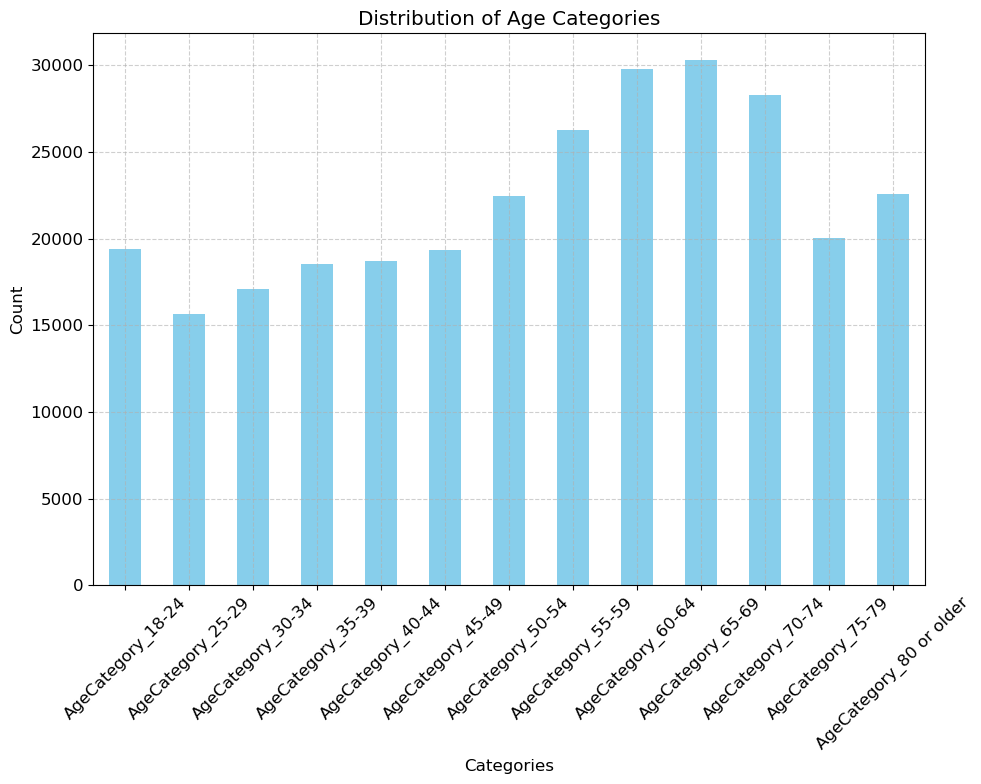

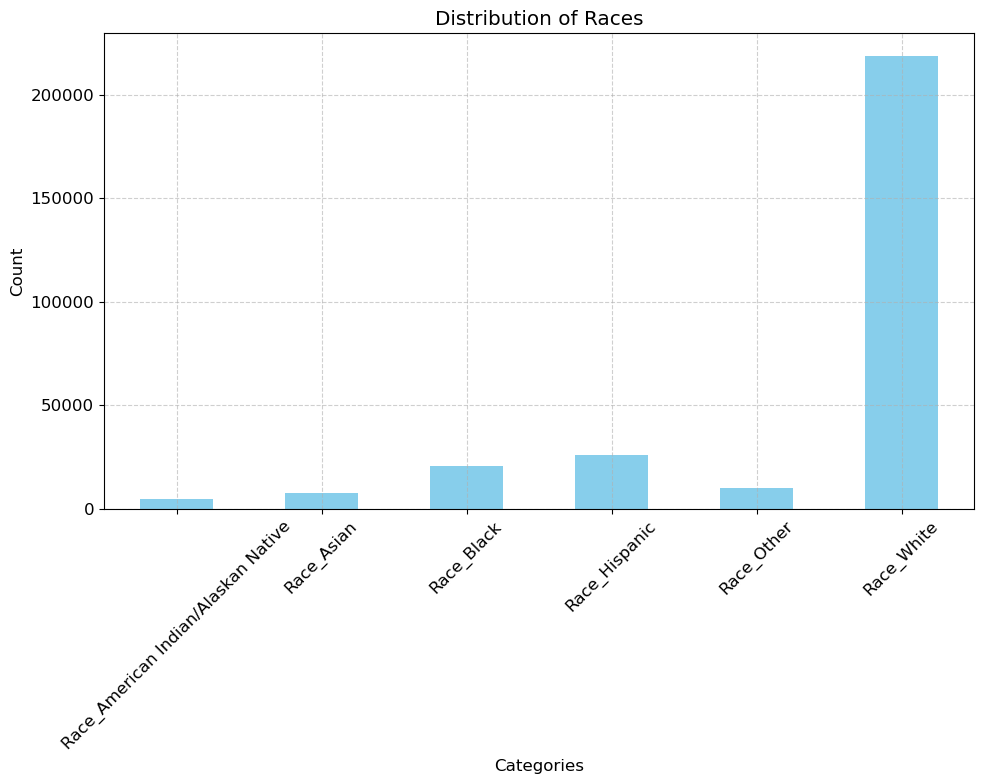

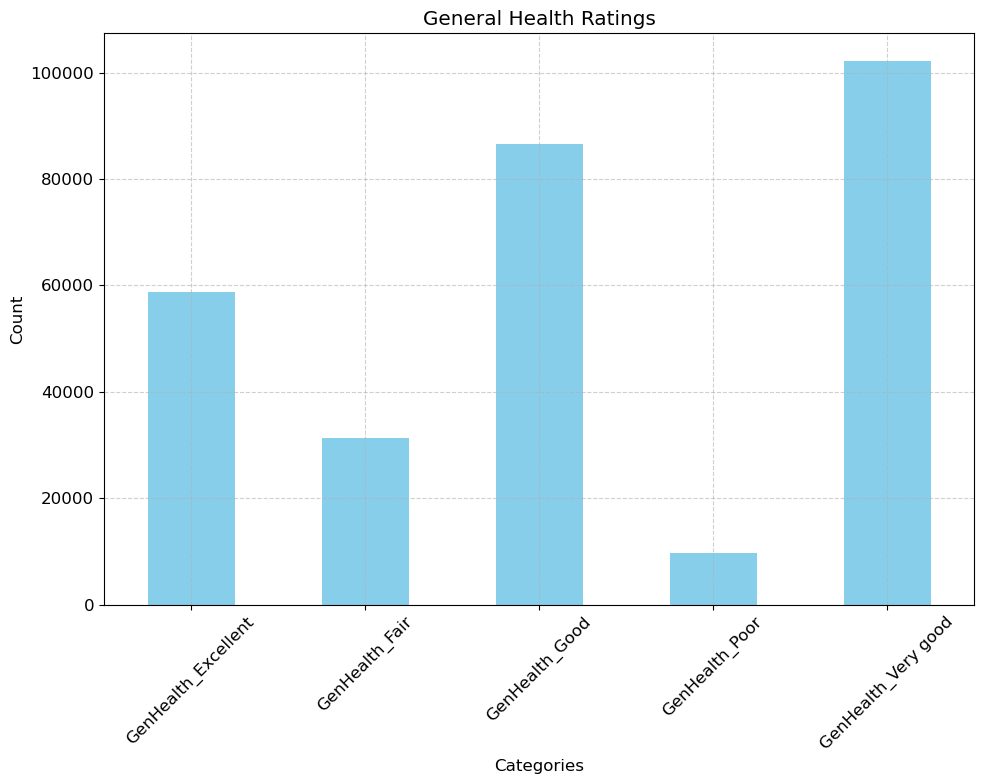

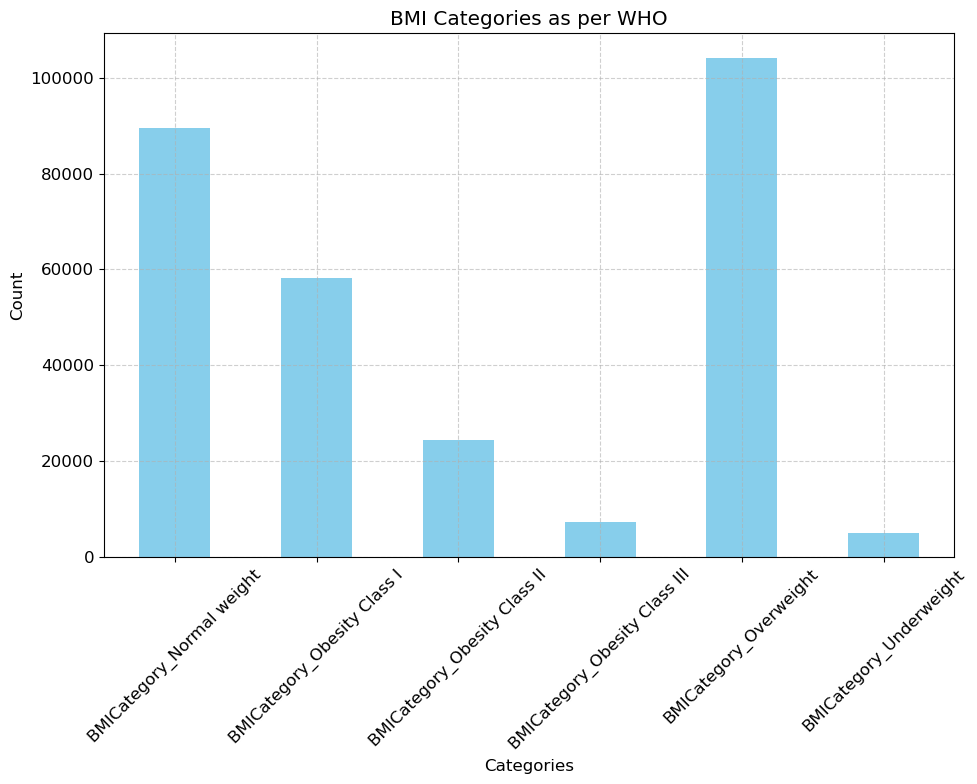

In [108]:
# Summing up the one-hot encoded columns for each category
age_sums = df_clean_onehot.filter(regex='AgeCategory').sum()
race_sums = df_clean_onehot.filter(regex='Race').sum()
gen_health_sums = df_clean_onehot.filter(regex='GenHealth').sum()
bmi_category_sums = df_clean_onehot.filter(regex='BMICategory').sum()

# Function to plot the data
def plot_data(data, title, ylabel):
    fig, ax = plt.subplots(figsize=(10, 8))
    data.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Categories')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plotting the results
plot_data(age_sums, 'Distribution of Age Categories', 'Count')
plot_data(race_sums, 'Distribution of Races', 'Count')
plot_data(gen_health_sums, 'General Health Ratings', 'Count')
plot_data(bmi_category_sums, 'BMI Categories as per WHO', 'Count')

Before:
Yes: 20440
No: 210356
After K mean SMOTE:
Yes: 210357
No: 210356


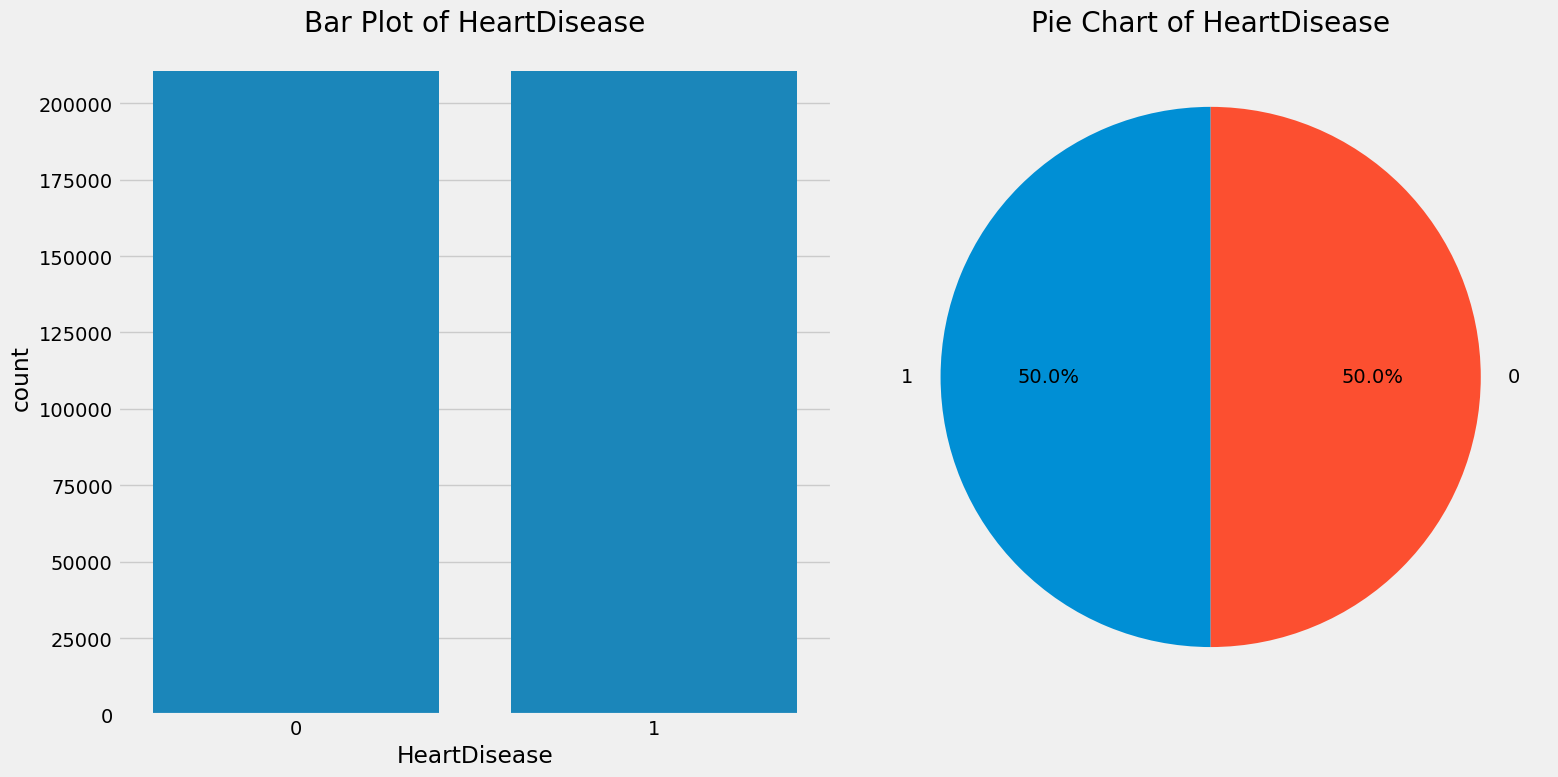

In [16]:
x,y = df_clean_onehot.drop(["HeartDisease"], axis=1), df_clean_onehot["HeartDisease"]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

counts_before = y_train.value_counts()
print("Before:")
print(f"Yes: {counts_before.get(1, 0)}")  # get(1, 0) returns the count of '1' (yes), defaults to 0 if not present
print(f"No: {counts_before.get(0, 0)}")  # get(0, 0) returns the count of '0' (no), defaults to 0 if not present

KSMOTE  = KMeansSMOTE(cluster_balance_threshold=0.1)
x_train, y_train = KSMOTE.fit_resample(x_train, y_train)

counts_after = y_train.value_counts()
print("After K mean SMOTE:")
print(f"Yes: {counts_after.get(1, 0)}")
print(f"No: {counts_after.get(0, 0)}")

f, axes = plt.subplots(1, 2, figsize=(16, 8))  # Use 2 subplots for bar and pie charts

# Prepare a DataFrame from the resampled data for easier plotting
df_heart = pd.DataFrame(x_train, columns=x_train.columns)
df_heart['HeartDisease'] = y_train

# Bar plot
sns.countplot(x='HeartDisease', data=df_heart, ax=axes[0])
axes[0].set_title('Bar Plot of HeartDisease')

# Pie chart
heart_disease_counts = df_heart['HeartDisease'].value_counts()
axes[1].pie(heart_disease_counts, labels=heart_disease_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Pie Chart of HeartDisease')
axes[1].set_ylabel('')  # Hide the y-label

plt.tight_layout()
plt.show()

Training for fold 1 ...
Epoch 1/3
10518/10518 ━━━━━━━━━━━━━━━━━━━━ 8s 711us/step - binary_accuracy: 0.9254 - loss: 0.2134
Epoch 2/3
10518/10518 ━━━━━━━━━━━━━━━━━━━━ 7s 711us/step - binary_accuracy: 0.9380 - loss: 0.1717
Epoch 3/3
10518/10518 ━━━━━━━━━━━━━━━━━━━━ 8s 719us/step - binary_accuracy: 0.9393 - loss: 0.1653
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
Score for fold 1: loss of 0.15229679644107819; compile_metrics of 94.32395100593567%

Training for fold 2 ...
Epoch 1/3
10518/10518 ━━━━━━━━━━━━━━━━━━━━ 8s 702us/step - binary_accuracy: 0.9251 - loss: 0.2169
Epoch 2/3
10518/10518 ━━━━━━━━━━━━━━━━━━━━ 7s 703us/step - binary_accuracy: 0.9381 - loss: 0.1704
Epoch 3/3
10518/10518 ━━━━━━━━━━━━━━━━━━━━ 7s 705us/step - binary_accuracy: 0.9391 - loss: 0.1652
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step
Score for fold 2: loss of 0.15389931201934814; compile_metrics of 94.31087374687195%

Training for

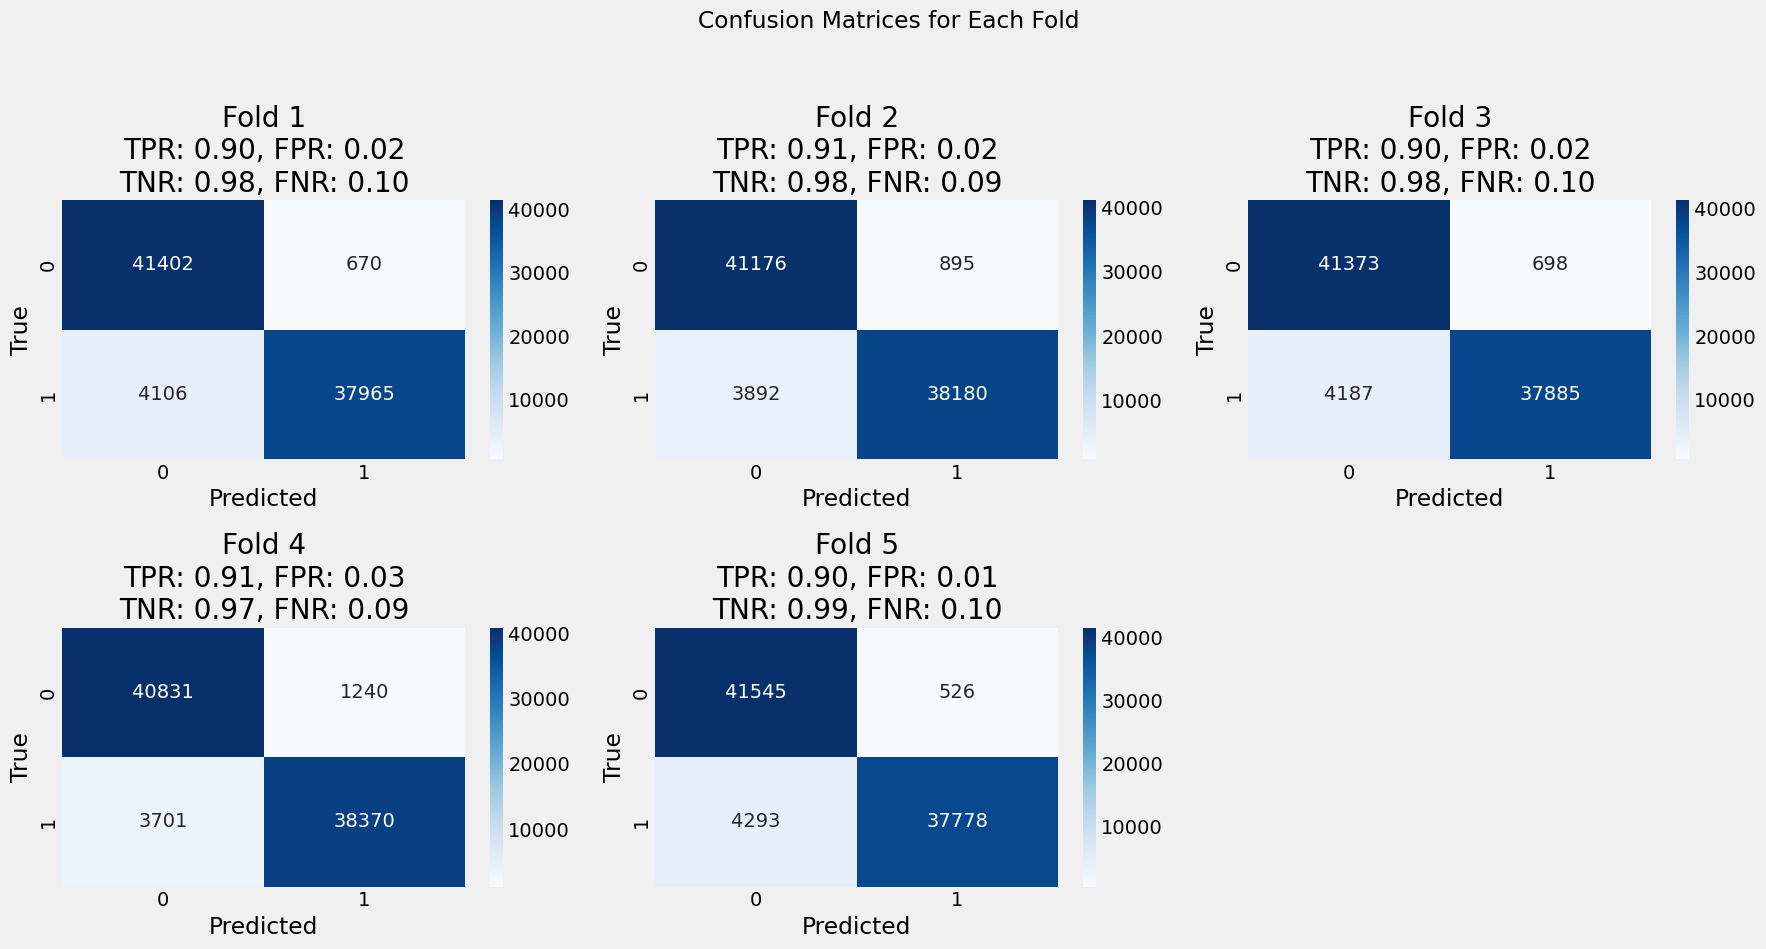

In [19]:
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_no = 1
losses = []
accuracies = []
# List to store confusion matrices
confusion_matrices = []
tpr_list = []  # List to store True Positive Rates
fpr_list = []  # List to store False Positive Rates
tnr_list = []  # List to store True Negative Rates
fnr_list = []  # List to store False Negative Rates

precision_list = []
recall_list = []
f1_score_list = []
auc_list = []

all_importances = pd.DataFrame()

# Define a wrapper class for Keras model
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y):
        # You can add fitting logic here if needed
        return self

    def score(self, X, y):
        loss, accuracy = self.keras_model.evaluate(X, y, verbose=0)
        return accuracy


# Get feature names
feature_names = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
                 'Diabetic', 'PhysicalActivity', 'Asthma', 'KidneyDisease']

for train, test in kfold.split(x_train, y_train):
    # Building the Model in the loop
    model = keras.Sequential([
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    
    # Fit the model using .iloc for proper indexing
    print(f'Training for fold {fold_no} ...')
    model.fit(x_train.iloc[train], y_train.iloc[train], 
              batch_size=32, epochs=3, verbose=1)
    
    # Evaluate the model on the test set using .iloc
    scores = model.evaluate(x_train.iloc[test], y_train.iloc[test], verbose=0)
    losses.append(scores[0])
    accuracies.append(scores[1] * 100)

    predictions = model.predict(x_train.iloc[test])
    predictions = (predictions > 0.5).astype(int)
    
    # Generate and store the confusion matrix
    cm = confusion_matrix(y_train.iloc[test], predictions)
    confusion_matrices.append(cm)

    wrapped_model = KerasClassifierWrapper(model)
    perm = PermutationImportance(wrapped_model, random_state=1).fit(x_train.iloc[test], y_train.iloc[test])
    
    fold_importance = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': perm.feature_importances_,
                                    'Fold': [f'Fold {fold_no}' for _ in range(len(x_train.columns))]})
    all_importances = pd.concat([all_importances, fold_importance], axis=0)

    y_pred = model.predict(x_train.iloc[test]).ravel()
    y_true = y_train.iloc[test]
    y_pred_bin = (y_pred > 0.5).astype(int)  # Binarizing predictions for confusion matrix and other metrics

    # Compute precision, recall, F1-score
    precision = precision_score(y_true, y_pred_bin)
    recall = recall_score(y_true, y_pred_bin)
    f1 = f1_score(y_true, y_pred_bin)

    # Compute AUC
    auc = roc_auc_score(y_true, y_pred)

    # Store the metrics
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)
    auc_list.append(auc)
    
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TNR = TN / (TN + FP)
    FNR = FN / (TP + FN)
    tpr_list.append(TPR)
    fpr_list.append(FPR)
    tnr_list.append(TNR)
    fnr_list.append(FNR)
    
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    print()   
    fold_no += 1

# Provide average scores
print(f'Average loss across all folds: {np.mean(losses):.5f}')
print(f'Average accuracy across all folds: {np.mean(accuracies)}%')
print(f'Average precision across all folds: {np.mean(precision_list):.5f}')
print(f'Average recall across all folds: {np.mean(recall_list):.5f}')
print(f'Average F1-score across all folds: {np.mean(f1_score_list):.5f}')
print(f'Average ROC-AUC across all folds: {np.mean(auc_list):.5f}')

# Plotting all confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Confusion Matrices for Each Fold')

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'Fold {i+1}\nTPR: {tpr_list[i]:.2f}, FPR: {fpr_list[i]:.2f}\nTNR: {tnr_list[i]:.2f}, FNR: {fnr_list[i]:.2f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

if len(confusion_matrices) < len(axes):
    for ax in axes[len(confusion_matrices):]:
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

                            Feature     mean      std
                     PhysicalHealth 0.091811 0.033005
                GenHealth_Very good 0.051077 0.015472
                     GenHealth_Good 0.038580 0.013511
                       MentalHealth 0.033824 0.005222
                GenHealth_Excellent 0.025467 0.008937
                  AgeCategory_18-24 0.019878 0.003006
                  AgeCategory_30-34 0.019399 0.003138
                  AgeCategory_35-39 0.017364 0.005006
                  AgeCategory_25-29 0.016592 0.002319
                  AgeCategory_60-64 0.016080 0.005521
                  AgeCategory_55-59 0.015627 0.005424
                  AgeCategory_40-44 0.015521 0.004503
                  AgeCategory_65-69 0.015018 0.005955
                  AgeCategory_45-49 0.014917 0.004760
                  AgeCategory_50-54 0.013993 0.004953
                     GenHealth_Fair 0.012412 0.003265
                  AgeCategory_70-74 0.011650 0.004676
                         Rac

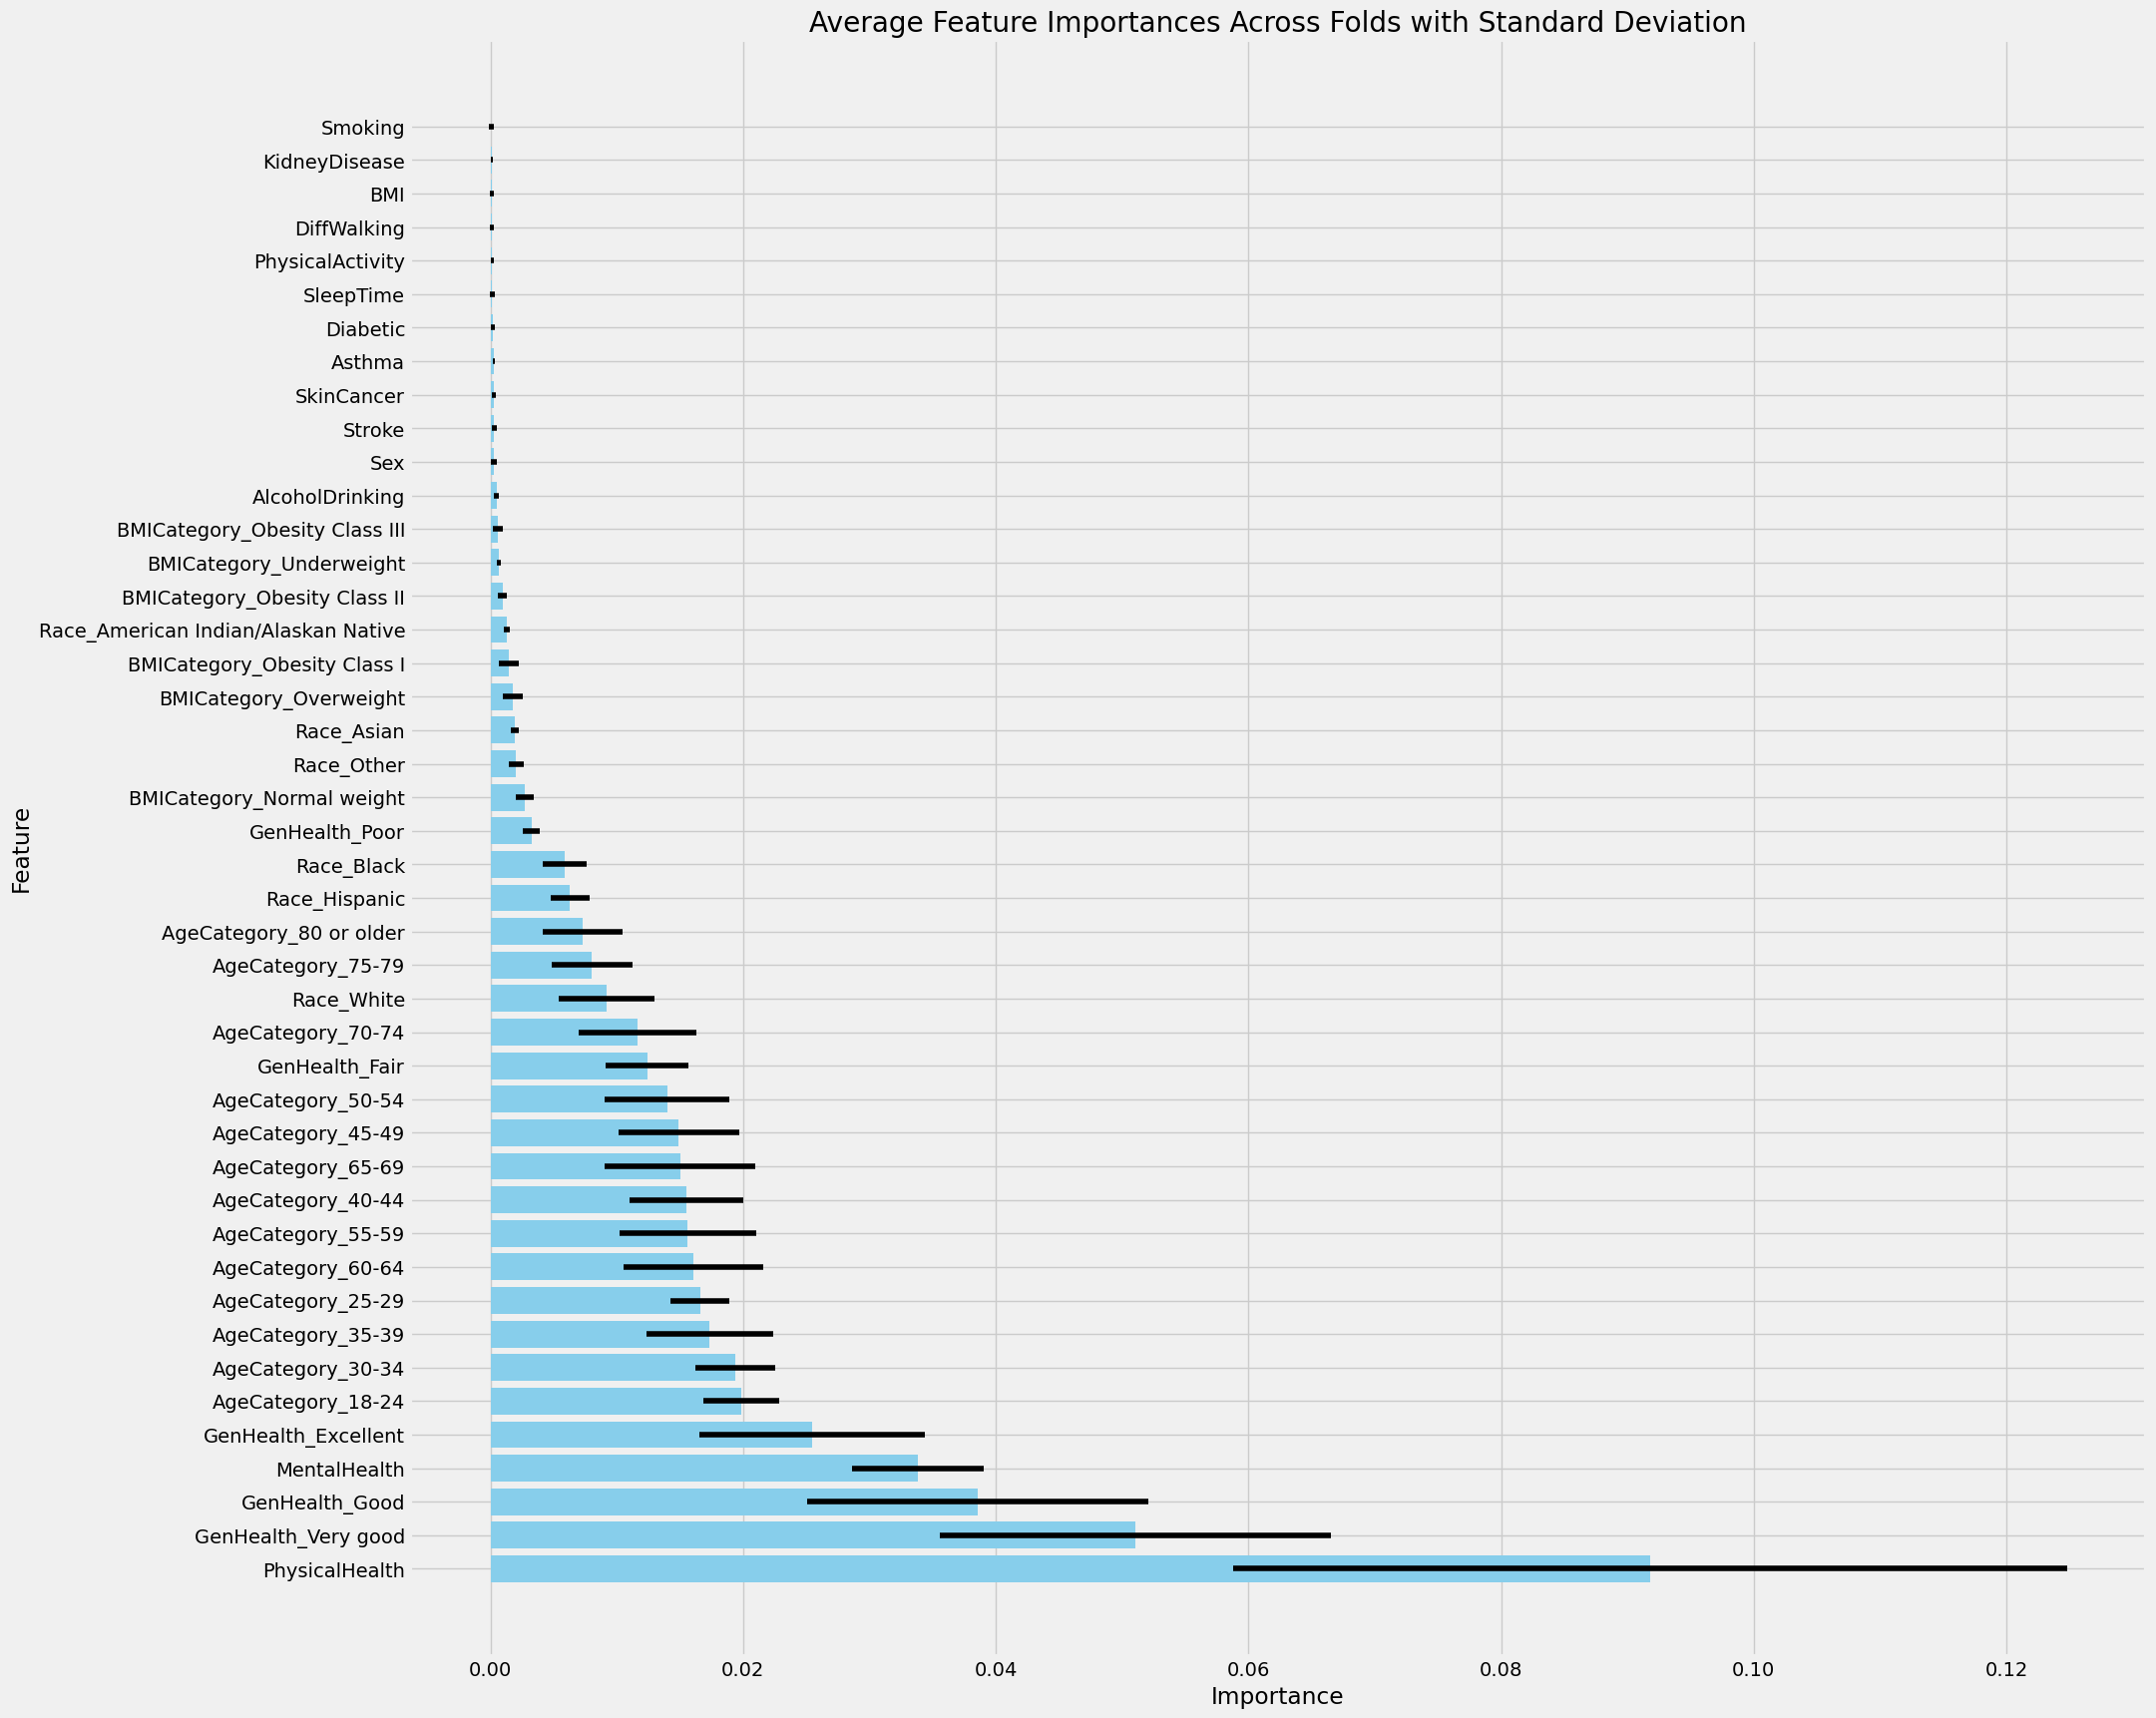

In [31]:
feature_stats = all_importances.groupby('Feature').Importance.agg(['mean', 'std']).reset_index()
feature_stats = feature_stats.sort_values(by='mean', ascending=False)

# Display the DataFrame in a well-formatted manner
print(feature_stats.to_string(index=False))

# Create the plot
plt.figure(figsize=(20, 20))
bars = plt.barh(feature_stats['Feature'], feature_stats['mean'], color='skyblue')
plt.barh(feature_stats['Feature'], feature_stats['mean'], xerr=feature_stats['std'], align='center', color='skyblue')
plt.title('Average Feature Importances Across Folds with Standard Deviation')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.show()